<a href="https://colab.research.google.com/github/aomidvar/alibabainpersia/blob/master/network_attack_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.4 MB/s eta 0:00:00


In [ ]:
from transformers import BertModel, BertTokenizer
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
import string
from tqdm import tqdm
import torch
import torch.nn as nn
from torchtext.vocab import GloVe, FastText
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
import gc
from sklearn import metrics
from collections import defaultdict
from sklearn.manifold import TSNE
tqdm.pandas()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
data_path = '/content/drive/MyDrive/attach_clustering.json'
data = pd.read_json(data_path)
data

In [ ]:
# removing punctuation
punctuation = string.punctuation
remove_punc = lambda sent: ' '.join([token for token in nltk.word_tokenize(sent) if token not in punctuation])
data['title'] = data['title'].progress_apply(remove_punc)
data['explanation'] = data['explanation'].progress_apply(remove_punc)

# removing stopwords
stopwords_list = set(stopwords.words('english'))
remove_stopword = lambda sent: ' '.join([token for token in nltk.word_tokenize(sent) if token not in stopwords_list])
data['title'] = data['title'].progress_apply(remove_stopword)
data['explanation'] = data['explanation'].progress_apply(remove_stopword)

# combine the title and explanation columns
data['text'] = data['title'] + 'EOT' + data['explanation']


100%|██████████| 2185/2185 [00:23<00:00, 91.29it/s] 


In [ ]:
data['label'].value_counts()

[]                                                                                      2149
[initial_access]                                                                          17
[resource_development]                                                                     4
[execution]                                                                                2
[initial_access, impact, resource_development]                                             1
[resource_development, defense_evasion, discovery]                                         1
[execution, privilege_escalation, execution]                                               1
[initial_access, privilege_escalation]                                                     1
[privilege_escalation, execution]                                                          1
[initial_access, initial_access, privilege_escalation, privilege_escalation]               1
[execution, collection, privilege_escalation]                         

In [ ]:
def first_label(label):
  if(len(label)>0):
    return label[0]
  else:
    return np.nan

labels = data['label'].progress_apply(first_label).dropna()
data_label = pd.DataFrame(np.transpose([data['text'][labels.index], labels]), columns=['text', 'label'], index=labels.index)
data_label

unique_labels = data_label['label'].unique()
label2id = dict(zip(unique_labels, range(len(unique_labels))))
data_label['label_id'] = data_label['label'].apply(lambda x: label2id[x])
data_label

100%|██████████| 2185/2185 [00:00<00:00, 207342.86it/s]


,text,label,label_id
9,use correlation rules top traditional signatur...,initial_access,0
20,use correlation rules top traditional signatur...,initial_access,0
32,use correlation rules top traditional signatur...,initial_access,0
44,use correlation rules top traditional signatur...,initial_access,0
56,use correlation rules top traditional signatur...,initial_access,0
68,use correlation rules top traditional signatur...,initial_access,0
80,use correlation rules top traditional signatur...,initial_access,0
92,use correlation rules top traditional signatur...,initial_access,0
104,use correlation rules top traditional signatur...,initial_access,0
297,delivery keyboyEOT’ outlined delivery phase re...,initial_access,0


100%|██████████| 2185/2185 [00:11<00:00, 183.47it/s]


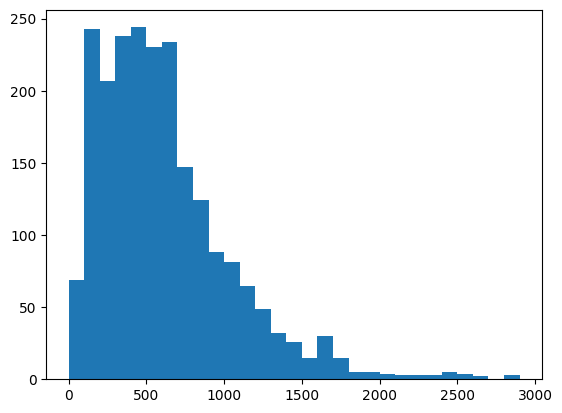

In [ ]:
sent_lens = [len(nltk.word_tokenize(sent)) for sent in tqdm(data['text'])]
plt.hist(sent_lens, bins=range(0, 3000, 100))
plt.show()

### represent the data with fasttext word embedding

In [ ]:
#
vocab = FastText(language = 'en')
embedding = nn.Embedding.from_pretrained(vocab.vectors)

.vector_cache/wiki.en.vec: 6.60GB [03:15, 33.7MB/s]                            
100%|██████████| 2519370/2519370 [08:03<00:00, 5209.39it/s]


In [ ]:
#
def get_fasttext_vectors(sent):
  return [np.array(vocab.get_vecs_by_tokens(token)) for token in nltk.word_tokenize(sent)]

fasttext_representing = data['text'].progress_apply(get_fasttext_vectors)

100%|██████████| 2185/2185 [00:58<00:00, 37.20it/s]


In [ ]:
#
#saving and loading fasttext vectors
with open('/content/drive/MyDrive/attack_fasttext.pkl', 'wb') as ff:
  pickle.dump(fasttext_representing, ff)

In [ ]:
#loading the fasttext vectors
with open('/content/drive/MyDrive/attack_fasttext.pkl', 'rb') as ff:
  fasttext_representing = pickle.load(ff)

In [ ]:
fasttext_mean = [np.array(sent).mean(axis=0) for sent in tqdm(fasttext_representing)]

100%|██████████| 2185/2185 [00:03<00:00, 634.44it/s] 


### representing with tf-idf approach


In [ ]:
vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    stop_words="english",
)
tfidf_representing = vectorizer.fit_transform(data['text']).toarray()

In [ ]:
#saving and loading the tf-idf representation
with open('/content/drive/MyDrive/attack_tf-idf.pkl', 'wb') as ff:
  pickle.dump(tfidf_representing, ff)

### represent average of fasttext with idf weights

In [ ]:
idf_dict = dict(zip(vectorizer.get_feature_names_out(), vectorizer.idf_))
weighted_average_fasttext = []
for i, item in tqdm(enumerate(data.text), total = len(data)):
    words = nltk.word_tokenize(item)
    weights = [idf_dict.get(word, 0) for word in words]
    embeddings = fasttext_representing[i]
    weighted_average_fasttext.append(np.average(embeddings, weights=weights, axis = 0))

    if i%1000 == 0:
        gc.collect()

100%|██████████| 2185/2185 [00:15<00:00, 145.31it/s]


In [ ]:
vectorizer.transform(data_label['text'])

<36x11532 sparse matrix of type '<class 'numpy.float64'>'
	with 8387 stored elements in Compressed Sparse Row format>

In [ ]:
data_representing = [
    {'title': 'average of fasttext word embedding',
     'data' : fasttext_mean,
     'labeled_data' : np.array(fasttext_mean, dtype='float')[data_label.index]

    },

    {'title': 'tf-idf',
     'data': tfidf_representing,
     'labeled_data': vectorizer.transform(data_label['text'])
    },

    {'title': 'weighted average of fasttext and tf-idf',
     'data': weighted_average_fasttext,
     'labeled_data': np.array(weighted_average_fasttext, dtype='float')[data_label.index]
    }
]

100%|██████████| 7/7 [00:00<00:00,  8.29it/s]


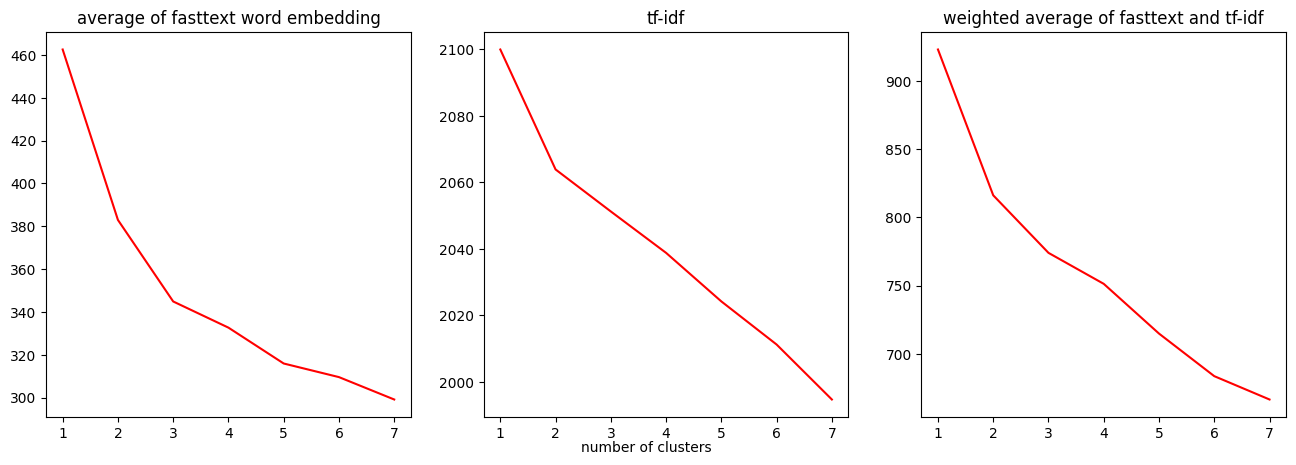

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
axs = axs.ravel()

for j in range(3):
  wcss = []
  for i in tqdm(range(1, 8)):
      kmeans = KMeans(n_clusters = i, init = 'k-means++', n_init = 'auto', random_state = 119)
      kmeans.fit(data_representing[j]['data'])
      wcss.append(kmeans.inertia_)
  axs[j].plot(range(1, 8), wcss, color='red')
  axs[j].set_title(data_representing[j]['title'])

fig.text(0.5, 0.04, 'number of clusters', ha='center')
plt.show()

In [ ]:
number_of_clusters = 5

## 2 clustering algourithms

In [ ]:
clustering_models = [
    {'title': 'k-means++',
     'model': KMeans(n_clusters = number_of_clusters, init = 'k-means++', n_init = 'auto')
    },
    {
     'title': 'minibatch kmeans',
     'model': MiniBatchKMeans(n_clusters=number_of_clusters, n_init='auto', init_size=1000, batch_size=1000)
    }
]

In [ ]:
evaluations = []
evaluations_std = []
tsne_results = []
gold_label = data_label['label_id']


def model_representer_evaluation(model, representer, n_runs=10):
  title = model['title'] + ' with ' + representer['title']
  print(title)
  scores = defaultdict(list)
  for seed in tqdm(range(n_runs)):
    model['model'].random_state = seed
    model['model'].fit(representer['data'])
    predicted_label = model['model'].predict(representer['labeled_data'])
    scores["Homogeneity"].append(metrics.homogeneity_score(gold_label, predicted_label))
    scores["Completeness"].append(metrics.completeness_score(gold_label, predicted_label))
    scores["V-measure"].append(metrics.v_measure_score(gold_label, predicted_label))
    scores["Adjusted Rand-Index"].append(metrics.adjusted_rand_score(gold_label, predicted_label))

  evaluation = {
          "estimator": title
      }
  evaluation_std = {
          "estimator": title
      }
  tsne_result = {
          "estimator": title
      }

  tsne_model = TSNE(n_components=2, perplexity=40, random_state=10)
  X_tsne = tsne_model.fit_transform(np.array(representer['data']))
  tsne_result['X'] = X_tsne[:,:]
  tsne_result['lables'] = model['model'].labels_

  for score_name, score_values in scores.items():
    mean_score, std_score = np.mean(score_values), np.std(score_values)
    print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
    evaluation[score_name] = mean_score
    evaluation_std[score_name] = std_score

  evaluations.append(evaluation)
  evaluations_std.append(evaluation_std)
  tsne_results.append(tsne_result)

In [ ]:
i = 1
all = len(clustering_models) * len(data_representing)
for model in clustering_models:
  for representer in data_representing:
    print(f'{i}/{all}')
    i += 1
    model_representer_evaluation(model, representer)
    print('----------------------------------')



1/6
k-means++ with average of fasttext word embedding


100%|██████████| 10/10 [00:00<00:00, 13.35it/s]


Homogeneity: 0.149 ± 0.114
Completeness: 0.647 ± 0.261
V-measure: 0.202 ± 0.148
Adjusted Rand-Index: 0.116 ± 0.129
----------------------------------
2/6
k-means++ with tf-idf


100%|██████████| 10/10 [00:21<00:00,  2.18s/it]


Homogeneity: 0.137 ± 0.101
Completeness: 0.548 ± 0.302
V-measure: 0.176 ± 0.128
Adjusted Rand-Index: 0.095 ± 0.133
----------------------------------
3/6
k-means++ with weighted average of fasttext and tf-idf


100%|██████████| 10/10 [00:00<00:00, 11.54it/s]


Homogeneity: 0.049 ± 0.074
Completeness: 0.787 ± 0.326
V-measure: 0.062 ± 0.095
Adjusted Rand-Index: 0.053 ± 0.081
----------------------------------
4/6
minibatch kmeans with average of fasttext word embedding


100%|██████████| 10/10 [00:00<00:00, 19.42it/s]


Homogeneity: 0.155 ± 0.108
Completeness: 0.649 ± 0.251
V-measure: 0.208 ± 0.140
Adjusted Rand-Index: 0.149 ± 0.100
----------------------------------
5/6
minibatch kmeans with tf-idf


100%|██████████| 10/10 [00:27<00:00,  2.75s/it]


Homogeneity: 0.148 ± 0.122
Completeness: 0.625 ± 0.308
V-measure: 0.177 ± 0.145
Adjusted Rand-Index: 0.097 ± 0.104
----------------------------------
6/6
minibatch kmeans with weighted average of fasttext and tf-idf


100%|██████████| 10/10 [00:00<00:00, 18.29it/s]


Homogeneity: 0.168 ± 0.113
Completeness: 0.468 ± 0.275
V-measure: 0.204 ± 0.128
Adjusted Rand-Index: 0.093 ± 0.147
----------------------------------


Text(0, 0.5, '')

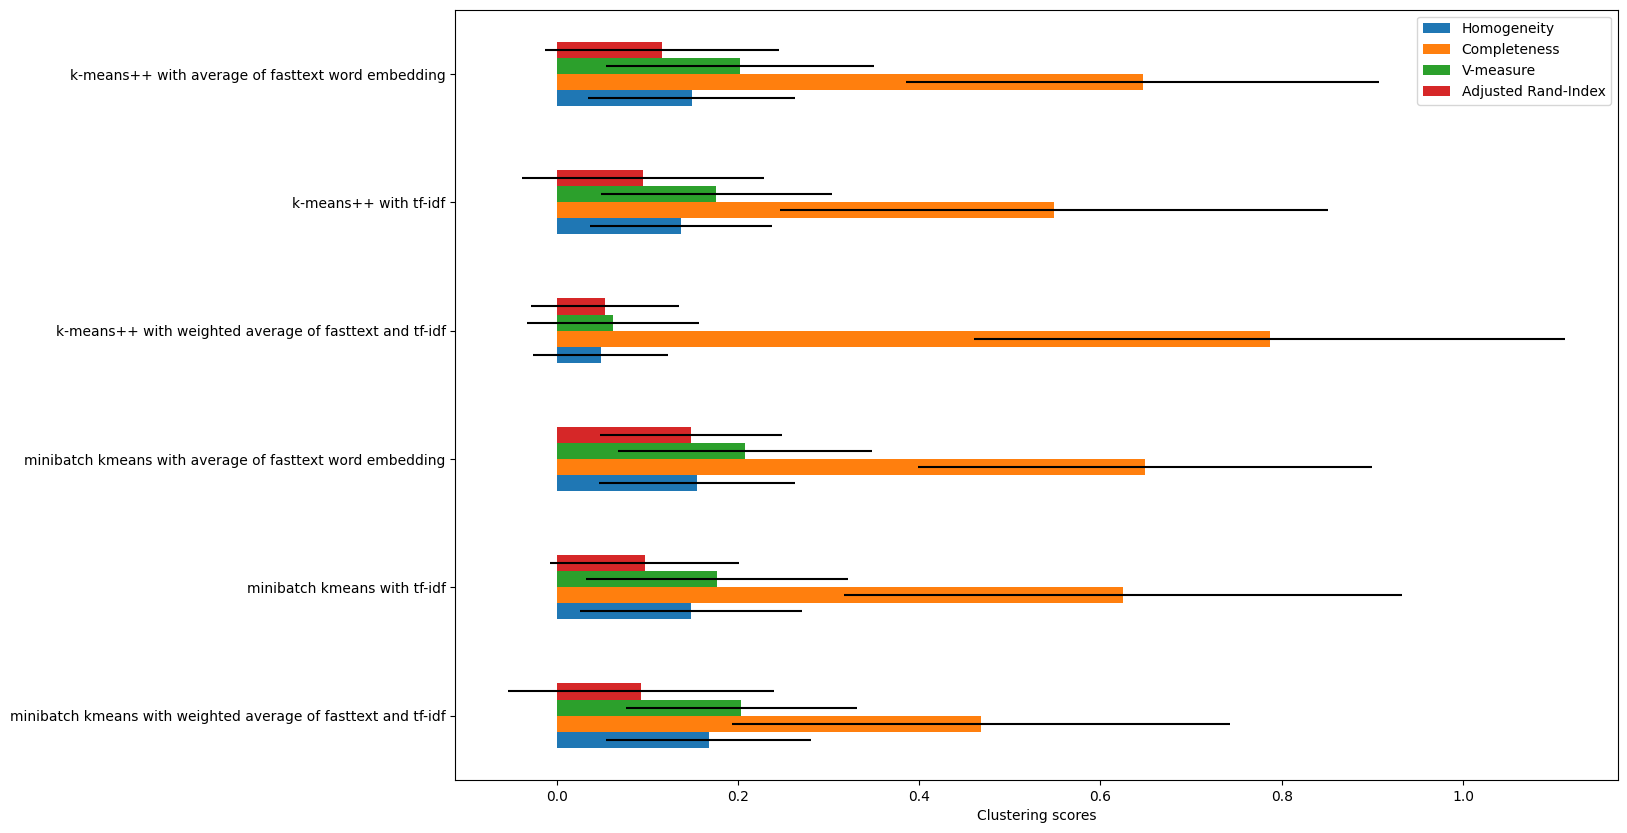

In [ ]:
fig, ax0 = plt.subplots(ncols=1, figsize=(15, 10), sharey=True)

df = pd.DataFrame(evaluations[::-1]).set_index("estimator")
df_std = pd.DataFrame(evaluations_std[::-1]).set_index("estimator")

df.plot.barh(ax=ax0, xerr=df_std)
ax0.set_xlabel("Clustering scores")
ax0.set_ylabel("")

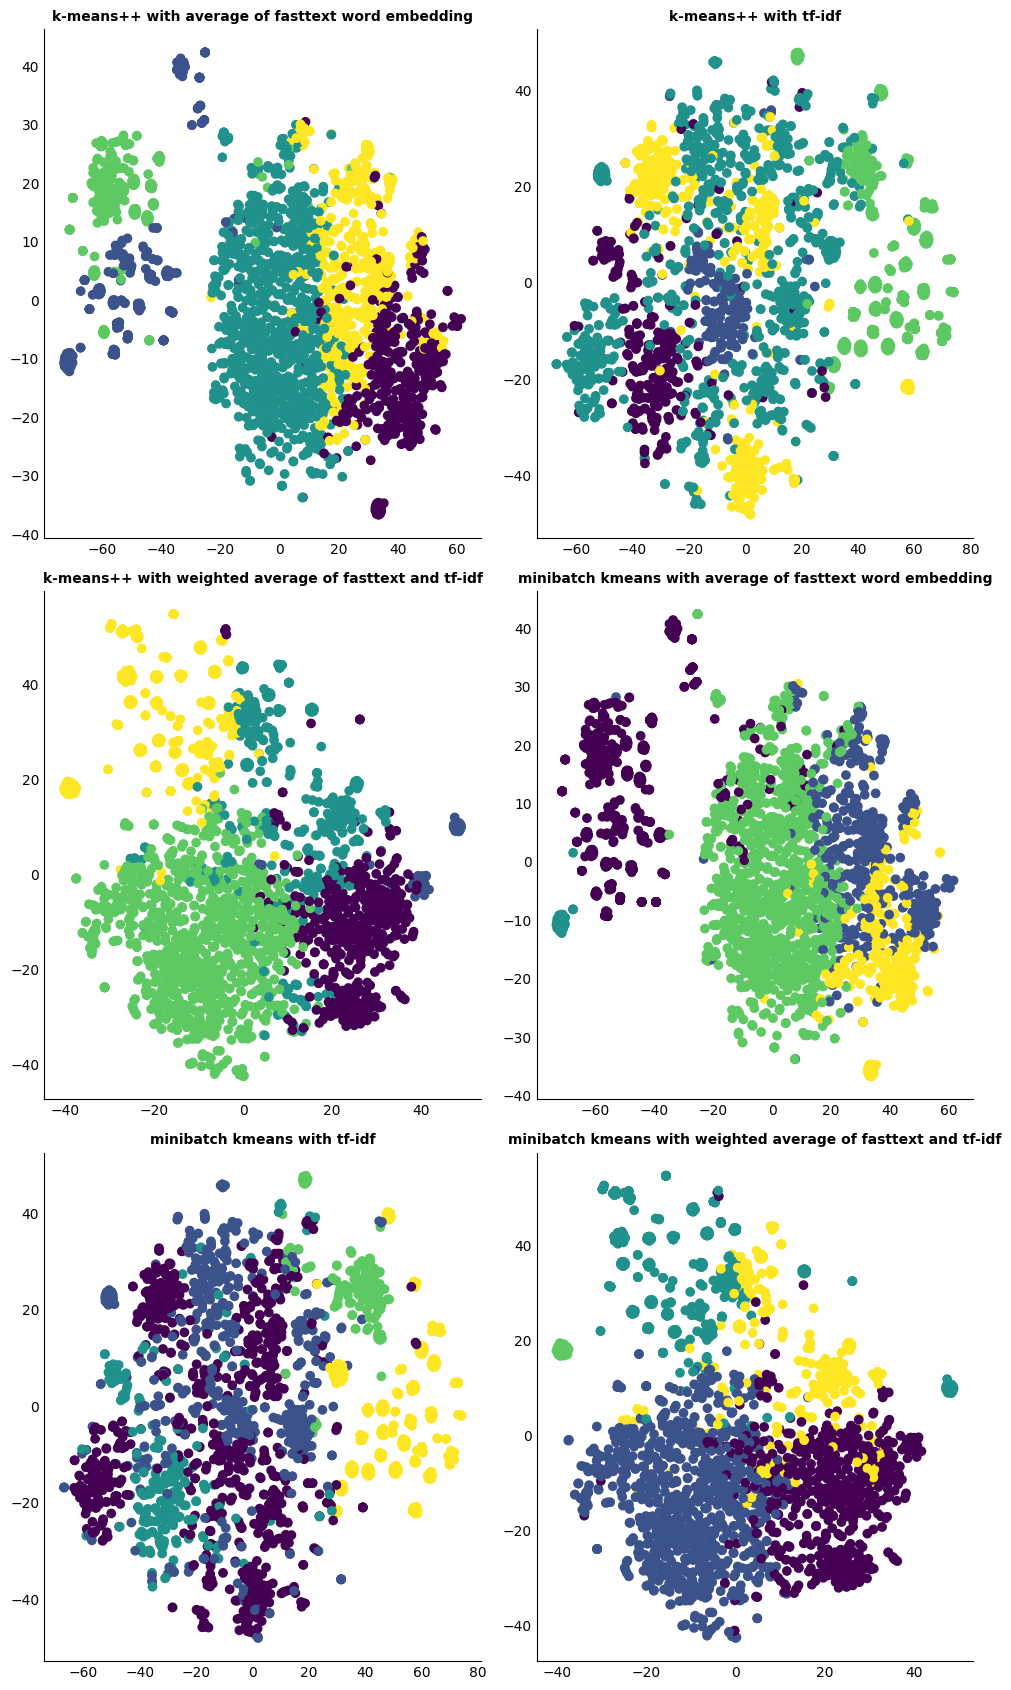

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(10, 17))
axs = axs.ravel()

for i, item in enumerate(tsne_results):

    axs[i].scatter(item['X'][:, 0], item['X'][:, 1], c=item['lables'])
    axs[i].set_title(item['estimator'], fontweight='bold', fontsize=10)  # Positioning the title at the bottom
    axs[i].tick_params(axis='both', which='both', length=0, labelsize=10)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)

plt.subplots_adjust(hspace=0.4)
plt.tight_layout()
plt.show()

In [ ]:
#represent the data with bert transformer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)


def get_bert_vector(sent):
  encoded_inputs = bert_tokenizer.encode_plus(sent,
                                           add_special_tokens=True,
                                           padding='max_length',
                                           truncation=True,
                                           max_length=500,
                                           return_tensors='pt')
  return model(**encoded_inputs)

with torch.no_grad():
  bert_representing = [get_bert_vector(sent) for sent in tqdm(data['text'])]



with open('/content/drive/MyDrive/attack_bert-base.pkl', 'wb') as ff:
  pickle.dump(bert_representing, ff)